## Build Eval Data
 - use helper functions in modules/EvalHelpers

In [1]:
import os, sys, copy, random, pickle
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.imgutils import (filter_pixels_circle, crop_img)

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, presetCubeViews, bytesToPic,
         croppedPic, bytesToPic2, colorInRange)

# from skimage.filters import sobel, gaussian, scharr, threshold_adaptive

from modules.IterThresh import iterThreshA
from modules.AnalysisHelpers import imgToColors, pointsToList

from modules.AnalysisHelpers import (applyTracker, roiSelectZoomWindow,
                                     roiSelectScoreWindow)
from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.AnalysisHelpers import subprocBatchOutput

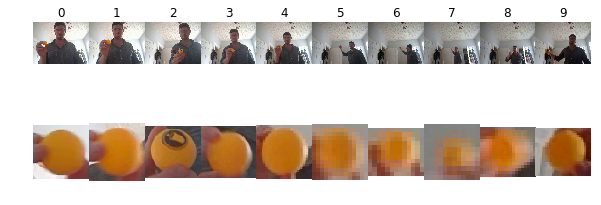

In [2]:
DATA_DIR = "../data/misc/books/analyze-orange-thresh-2/"

db_name = "gs_baseframes.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGS = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

chart_data = []

for _gs in listGS:
    _gs.initDisplay()
    tmp = []
    tmp.append(_gs.getOrigFrame())
    tmp.append(_gs.display.scoreFrame.copy())
    chart_data.append(tmp)

multiPlot( chart_data, hspace = 0, wspace = 0, figsize = (10,4)
          ,input_frame_titles = range(len(chart_data))
          ,bForceTitles = False
          ,bGrid=False)

In [72]:
tracker = TrackFactory(on=True)
tracker.setInit(ballColor = "orange")
tracker.setAlgoEnum(1)

In [73]:
from modules.EvalHelpers import EvalTracker, EvalDataset

In [74]:
evData = EvalDataset()

### Manipulation of Pandas : prettify w/o changing underlying schema

In [6]:
evData.buildDataset(listGS, tracker)

# view prettified output
evData.getDatasetDisplay()

,list Index,frame Counter,check Both Contains Other,distance From Baseline,check Baseline Inside Track,check Either Contains Other,check Track In Window,check Track Inside Baseline,check Track Inside Baseline Rect,check Track Success,compare Radii
0,0,0,True,2.83,True,True,None,True,False,True,6.00
1,1,9,True,9.43,True,True,None,True,False,True,8.00
2,2,78,True,1.00,True,True,None,True,True,True,-1.00
3,3,116,True,3.61,True,True,None,True,False,True,3.00
4,4,136,True,4.12,True,True,None,True,False,True,2.00
5,5,176,True,4.12,True,True,None,True,False,True,0.00
6,6,195,False,5.39,False,False,None,False,False,True,-2.00
7,7,246,True,1.00,True,True,None,True,True,True,-1.00
8,8,307,False,9.22,False,False,None,False,False,True,-3.00
9,9,340,True,3.16,True,True,None,True,False,True,1.00


In [7]:
# notice how original df is not changed by formatting output
print evData.getDataset().columns
evData.getDataset()

Index([u'checkBaselineInsideTrack', u'checkBothContainsOther',
       u'checkEitherContainsOther', u'checkTrackInWindow',
       u'checkTrackInsideBaseline', u'checkTrackInsideBaselineRect',
       u'checkTrackSuccess', u'compareRadii', u'distanceFromBaseline',
       u'frameCounter', u'listIndex'],
      dtype='object')


,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInWindow,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline,frameCounter,listIndex
0,True,True,True,None,True,False,True,6,2.828427,0,0
1,True,True,True,None,True,False,True,8,9.433981,9,1
2,True,True,True,None,True,True,True,-1,1.000000,78,2
3,True,True,True,None,True,False,True,3,3.605551,116,3
4,True,True,True,None,True,False,True,2,4.123106,136,4
5,True,True,True,None,True,False,True,0,4.123106,176,5
6,False,False,False,None,False,False,True,-2,5.385165,195,6
7,True,True,True,None,True,True,True,-1,1.000000,246,7
8,False,False,False,None,False,False,True,-3,9.219544,307,8
9,True,True,True,None,True,False,True,1,3.162278,340,9


In [118]:
df = evData.getDataset()

### Debug / Test --batchoutput

In [58]:
from modules.AnalysisHelpers import subprocBatchOutput

In [52]:
frame_inds = [0,10,100,200,800]

myGS = subprocBatchOutput(f_pathfn = "data/proc/raw/oct20/output4.avi"
                         ,batch_list = frame_inds
                         )

In [53]:
[_gs.frameCounter for _gs in myGS]

[0, 10, 100, 200]

### Build expanded dataset (manually) then import automatically

In [46]:
# standard gs loading script
db_name = "../data/usr/interproc.db"
db = DBInterface(db_name)
listGS = [ pickle.loads(d[1]) for d in db.selectAll()]
db = None

In [68]:
newGS = subprocBatchOutput(
              f_pathfn = "data/proc/tmp/dec14/output5.proc1.proc1.avi"
             ,batch_enum = 3
             ,db_pathfn = "data/usr/eval_data_1_larger.db"
             )

In [70]:
print [_gs.frameCounter for _gs in newGS]

[0, 9, 78, 116, 136, 176, 187, 194, 195, 201, 215, 246, 270, 292, 295, 307, 308, 324, 340]


In [71]:
[_gs.displayInputScore['0'] for _gs in listGS]

[{u'data': [107, 214, 54, 52], u'type': u'circle'},
 {u'data': [194, 200, 52, 53], u'type': u'circle'},
 {u'data': [385, 307, 54, 51], u'type': u'circle'},
 {u'data': [342, 302, 42, 39], u'type': u'circle'},
 {u'data': [268, 267, 32, 31], u'type': u'circle'},
 {u'data': [328, 264, 12, 12], u'type': u'circle'},
 {u'data': [361, 270, 9, 10], u'type': u'circle'},
 {u'data': [369, 279, 10, 9], u'type': u'circle'},
 {u'data': [369, 280, 11, 9], u'type': u'circle'},
 {u'data': [378, 280, 9, 9], u'type': u'circle'},
 {u'data': [375, 275, 10, 9], u'type': u'circle'},
 {u'data': [302, 290, 8, 7], u'type': u'circle'},
 {u'data': [253, 299, 10, 9], u'type': u'circle'},
 {u'data': [382, 317, 11, 11], u'type': u'circle'},
 {u'data': [390, 324, 11, 12], u'type': u'circle'},
 {u'data': [357, 344, 16, 14], u'type': u'circle'},
 {u'data': [345, 347, 12, 13], u'type': u'circle'},
 {u'data': [152, 360, 17, 16], u'type': u'circle'},
 {u'data': [113, 310, 28, 24], u'type': u'circle'}]

### View Expanded Dataset

In [75]:
evData = EvalDataset()
evData.buildDataset(newGS, tracker)
evData.getDatasetDisplay()

,list Index,frame Counter,check Both Contains Other,distance From Baseline,check Baseline Inside Track,check Either Contains Other,check Track In Window,check Track Inside Baseline,check Track Inside Baseline Rect,check Track Success,compare Radii
0,0,0,True,2.24,True,True,None,True,False,True,6.00
1,1,9,True,7.21,True,True,None,True,False,True,7.00
2,2,78,True,1.41,True,True,None,True,False,True,-1.00
3,3,116,True,4.47,True,True,None,True,False,True,3.00
4,4,136,True,4.12,True,True,None,True,False,True,2.00
5,5,176,True,5.39,True,True,None,True,False,True,0.00
6,6,187,False,5.39,False,False,None,False,False,True,-1.00
7,7,194,False,6.00,False,False,None,False,False,True,-2.00
8,8,195,False,4.00,False,False,None,False,False,True,-1.00
9,9,201,False,4.12,False,False,None,False,False,True,-3.00


In [77]:
# next step... filtering table and then printing analysis 
# e.g. index17 - bothContainsOther=F but eitherContainsOther=T; what gives?